# 공공데이터포털 오픈API활용 기상청 지상(종관,ASOS)일자료 조회 

https://www.data.go.kr/data/15059093/openapi.do

## 1) 라이브러리 임포트

In [157]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
%matplotlib inline

In [158]:
# 경고 메시지 무시, 글시체 설정
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

## 2) 데이터 전처리

### 2.1) 데이터 타입 변경 및 중복 값 처리

In [159]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, '데이터')
weather_orig_path = os.path.join(data_dir, r'원본(크롤링)\weather_orig.csv')

In [160]:
df = pd.read_csv(weather_orig_path, encoding='cp949')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35133 entries, 0 to 35132
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stnId   35133 non-null  int64  
 1   stnNm   35133 non-null  object 
 2   tm      35133 non-null  object 
 3   avgWs   35038 non-null  float64
 4   avgTa   35076 non-null  float64
 5   sumRn   14407 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.6+ MB


In [162]:
# 날짜 데이터 타입 변경
df.tm = pd.to_datetime(df.tm)

In [163]:
# 중복 값 제거
df = df.drop_duplicates()

In [164]:
len(df)

35133

### 2.2) 결측치처리
1. 자료가 없는 날짜 탐색 후 결측치 처리
2. 자료가 공백인 곳은 관측하지 않은 지점.
3. 강수량의 경우 기상청 예보 비교 결과 강수량이 0인경우에도 자료가 공백.

https://www.weather.go.kr/wnuri_help/html/observation/past-obs.jsp

In [165]:
df.isnull().sum()

stnId        0
stnNm        0
tm           0
avgWs       95
avgTa       57
sumRn    20726
dtype: int64

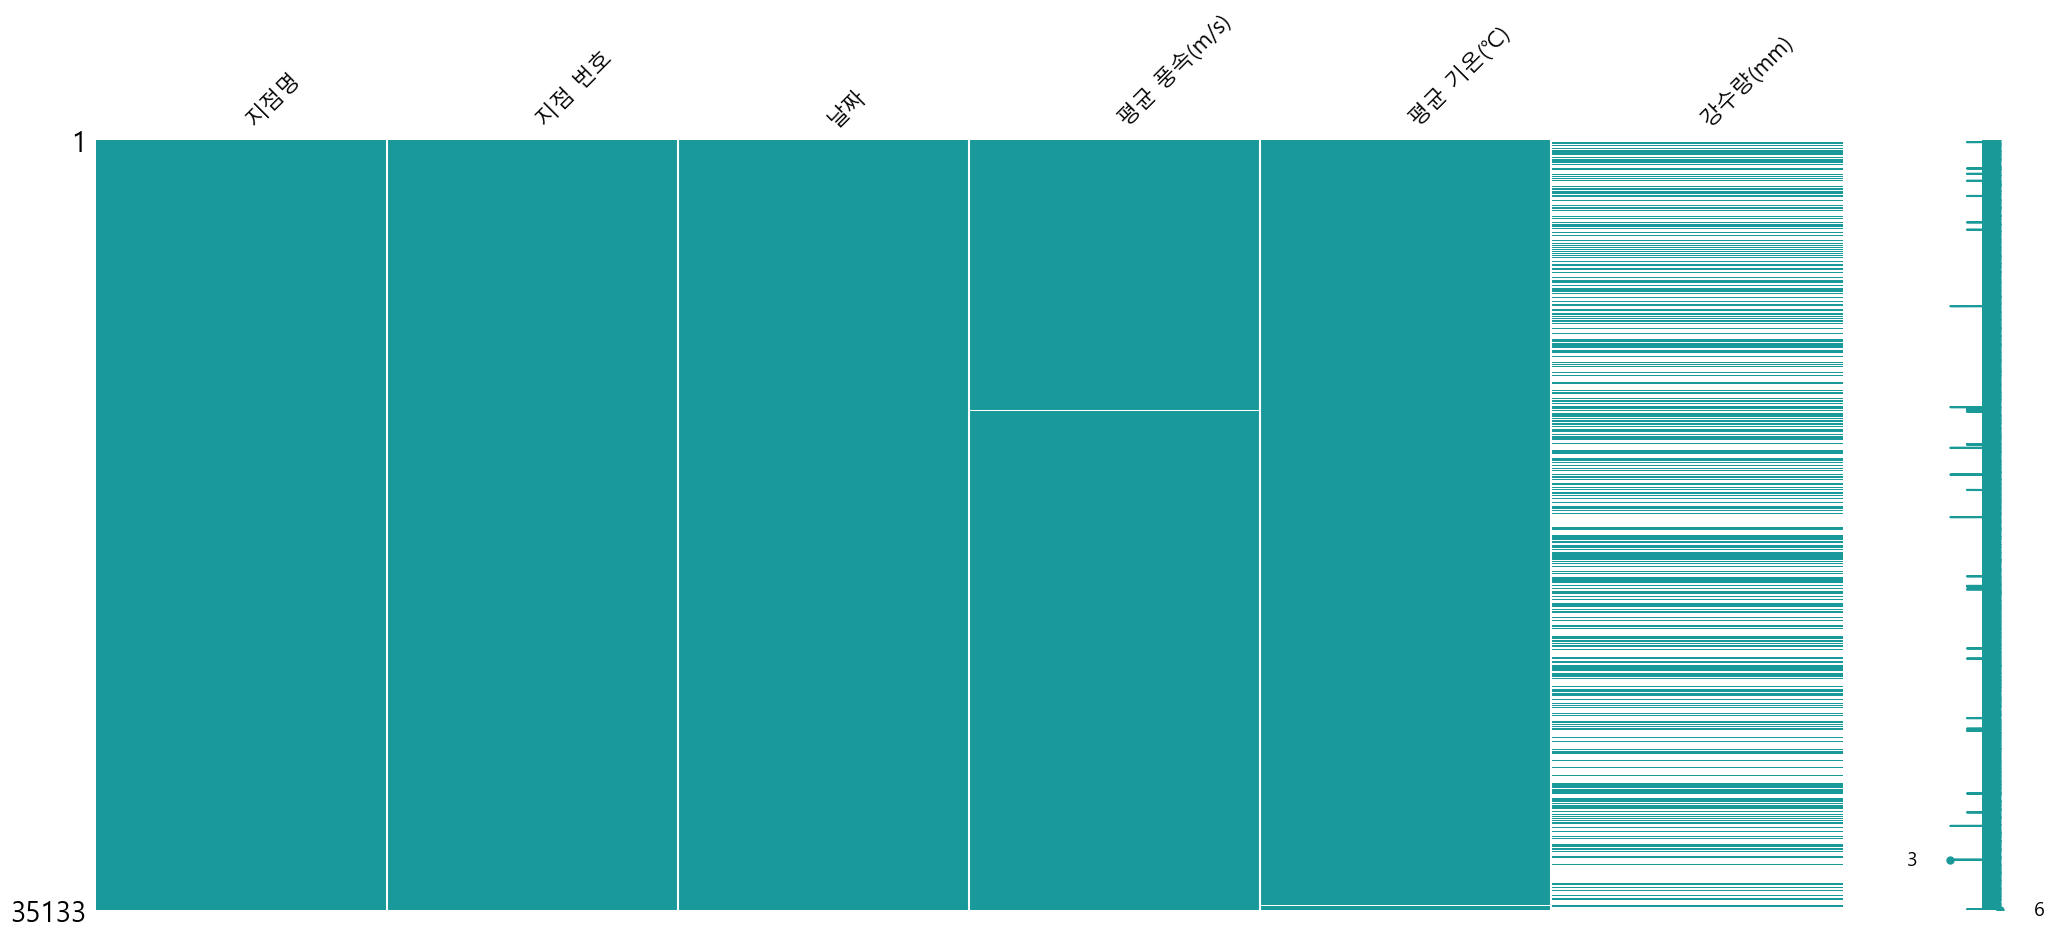

In [166]:
temp = df.copy()
temp.columns = ['지점명', '지점 번호', '날짜', '평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
msno.matrix(temp, color=(0.1, 0.6, 0.6))
plt.show()

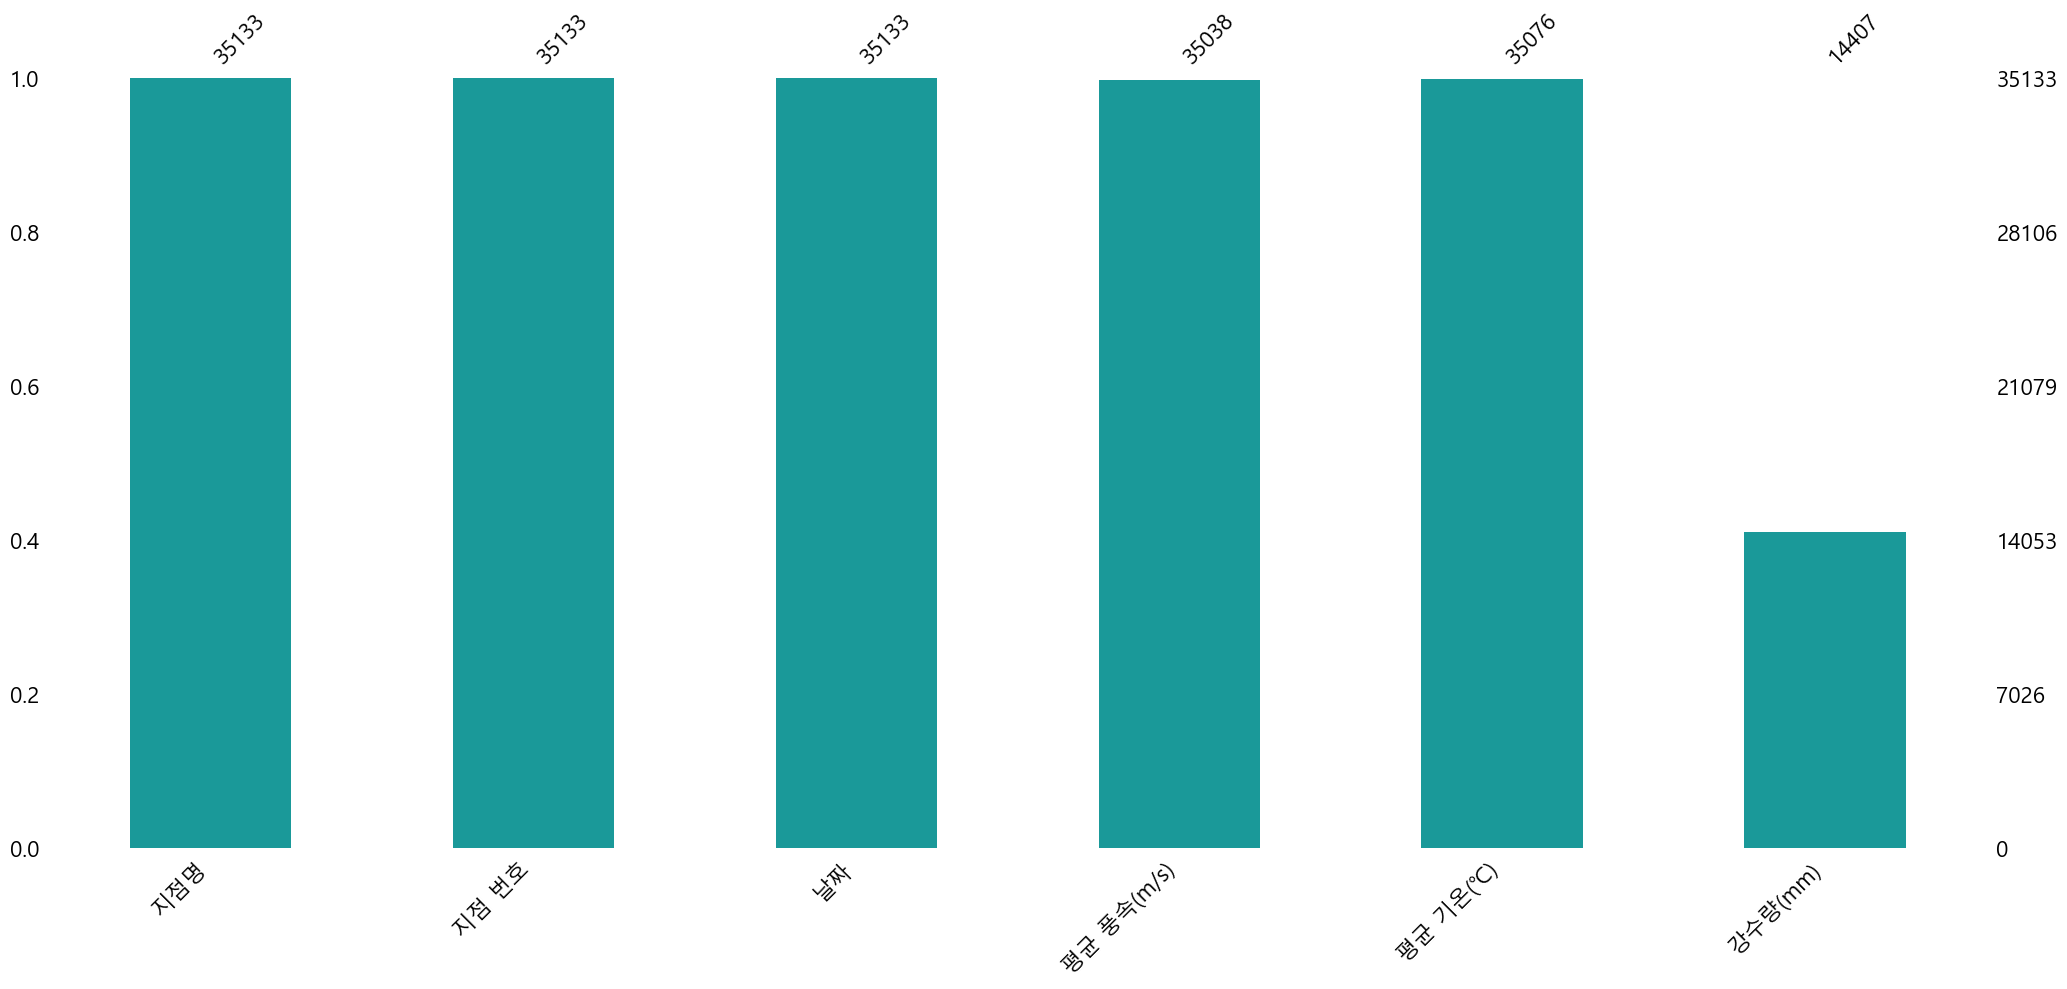

In [167]:
temp = df.copy()
temp.columns = ['지점명', '지점 번호', '날짜', '평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
msno.bar(temp, color=(0.1, 0.6, 0.6))
plt.show()

In [168]:
''' 
결측치 처리 방법 
1. 날짜는 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 
2. 평균 풍속, 평균 기온은 전일 값으로 채우기
3. 강수량은 0으로 채우기
'''

' \n결측치 처리 방법 \n1. 날짜는 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 \n2. 평균 풍속, 평균 기온은 전일 값으로 채우기\n3. 강수량은 0으로 채우기\n'

#### 2.2.1) 날짜

In [169]:
tm_count = df.groupby(['stnId', 'stnNm'])['tm'].count()
tm_count

stnId  stnNm
90     속초       366
93     북춘천      366
95     철원       366
98     동두천      366
99     파주       366
               ... 
285    합천       366
288    밀양       366
289    산청       366
294    거제       366
295    남해       366
Name: tm, Length: 96, dtype: int64

In [170]:
tm_count.unique()

array([366, 365], dtype=int64)

In [171]:
tm_count = tm_count.to_frame()
missing_tm_stnId = tm_count[tm_count.values==365]
missing_tm_stnId

,,tm
stnId,stnNm,
101,춘천,365
172,고창,365
271,봉화,365


In [172]:
# 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 
for stnId, stnNm in missing_tm_stnId.index:
    date_range = pd.date_range(df[df.stnNm==stnNm]['tm'].min(), df[df.stnNm==stnNm]['tm'].max())
    missing_dates = date_range.difference(df[df.stnNm==stnNm]['tm'])
    missing_data = pd.DataFrame({'stnId':[stnId] * len(missing_dates),
        'stnNm': [stnNm] * len(missing_dates),
        'tm': missing_dates})
    df = pd.concat([df, missing_data], ignore_index=True)
    print(f'{stnNm} 날짜 결측치 : {missing_dates}')

춘천 날짜 결측치 : DatetimeIndex(['2024-12-25'], dtype='datetime64[ns]', freq='D')
고창 날짜 결측치 : DatetimeIndex(['2024-05-20'], dtype='datetime64[ns]', freq='D')
봉화 날짜 결측치 : DatetimeIndex(['2024-08-23'], dtype='datetime64[ns]', freq='D')


In [173]:
# 추가된 데이터 확인 
df[(df.stnNm=='고창')&(df.tm=='2024-05-20')]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
35134,172,고창,2024-05-20,NaN,NaN,NaN


In [174]:
# 날짜 결측치 검증
tm_count = df.groupby('stnNm')['tm'].count()
tm_count.unique()

array([366], dtype=int64)

#### 2.2.2) 평균 풍속 및 평균 기온

In [175]:
df.loc[(pd.isna(df.avgWs))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
1863,100,대관령,2024-02-03,NaN,-3.5,NaN
1864,100,대관령,2024-02-04,NaN,-2.5,0.0
1880,100,대관령,2024-02-20,NaN,-1.8,4.5
1881,100,대관령,2024-02-21,NaN,-3.7,31.1
1882,100,대관령,2024-02-22,NaN,-6.4,14.3
...,...,...,...,...,...,...
32838,283,경주시,2024-09-24,NaN,NaN,NaN
35100,295,남해,2024-11-29,NaN,7.1,NaN
35133,101,춘천,2024-12-25,NaN,NaN,NaN
35134,172,고창,2024-05-20,NaN,NaN,NaN


In [176]:
df.loc[(pd.isna(df.avgTa))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
1,90,속초,2024-01-02,1.8,NaN,0.0
95,90,속초,2024-04-05,1.4,NaN,NaN
1296,98,동두천,2024-07-17,1.4,NaN,71.1
1297,98,동두천,2024-07-18,1.0,NaN,NaN
1545,99,파주,2024-03-22,2.7,NaN,1.4
1546,99,파주,2024-03-23,1.2,NaN,NaN
2554,101,춘천,2024-12-24,0.7,NaN,NaN
2555,101,춘천,2024-12-26,1.9,NaN,0.0
3534,105,강릉,2024-08-29,1.8,NaN,40.4
3756,106,동해,2024-04-07,2.3,NaN,NaN


In [177]:
# 평균 풍속, 평균 기온 결측치 전일 값으로 채우기
df[['avgWs', 'avgTa']] = df[['avgWs', 'avgTa']].fillna(method='ffill')

#### 2.2.3) 강수량

In [178]:
df.loc[(pd.isna(df.sumRn))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
2,90,속초,2024-01-03,1.6,3.1,NaN
3,90,속초,2024-01-04,1.9,2.9,NaN
4,90,속초,2024-01-05,2.6,7.7,NaN
5,90,속초,2024-01-06,2.1,2.8,NaN
6,90,속초,2024-01-07,2.7,-2.3,NaN
...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,NaN
35132,295,남해,2024-12-31,1.7,5.5,NaN
35133,101,춘천,2024-12-25,1.7,5.5,NaN
35134,172,고창,2024-05-20,1.7,5.5,NaN


In [179]:
# 강수량은 결측치 0으로 채우기
df['sumRn'] = df['sumRn'].fillna(0)

In [180]:
# 최종 결측치 확인
df.isnull().sum()

stnId    0
stnNm    0
tm       0
avgWs    0
avgTa    0
sumRn    0
dtype: int64

In [181]:
df

,stnId,stnNm,tm,avgWs,avgTa,sumRn
0,90,속초,2024-01-01,1.0,2.7,0.4
1,90,속초,2024-01-02,1.8,2.7,0.0
2,90,속초,2024-01-03,1.6,3.1,0.0
3,90,속초,2024-01-04,1.9,2.9,0.0
4,90,속초,2024-01-05,2.6,7.7,0.0
...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,0.0
35132,295,남해,2024-12-31,1.7,5.5,0.0
35133,101,춘천,2024-12-25,1.7,5.5,0.0
35134,172,고창,2024-05-20,1.7,5.5,0.0


## 3) EDA

In [182]:
df.describe()

,stnId,tm,avgWs,avgTa,sumRn
count,35136.000000,35136,35136.000000,35136.000000,35136.000000
mean,197.177083,2024-07-01 12:00:00,1.892865,14.673139,3.955556
min,90.000000,2024-01-01 00:00:00,0.100000,-17.500000,0.000000
25%,136.750000,2024-04-01 00:00:00,1.000000,5.900000,0.000000
50%,201.500000,2024-07-01 12:00:00,1.500000,15.500000,0.000000
75%,257.250000,2024-10-01 00:00:00,2.300000,23.500000,0.700000
max,295.000000,2024-12-31 00:00:00,20.200000,33.300000,397.700000
std,64.030526,NaN,1.349127,9.740576,14.777776


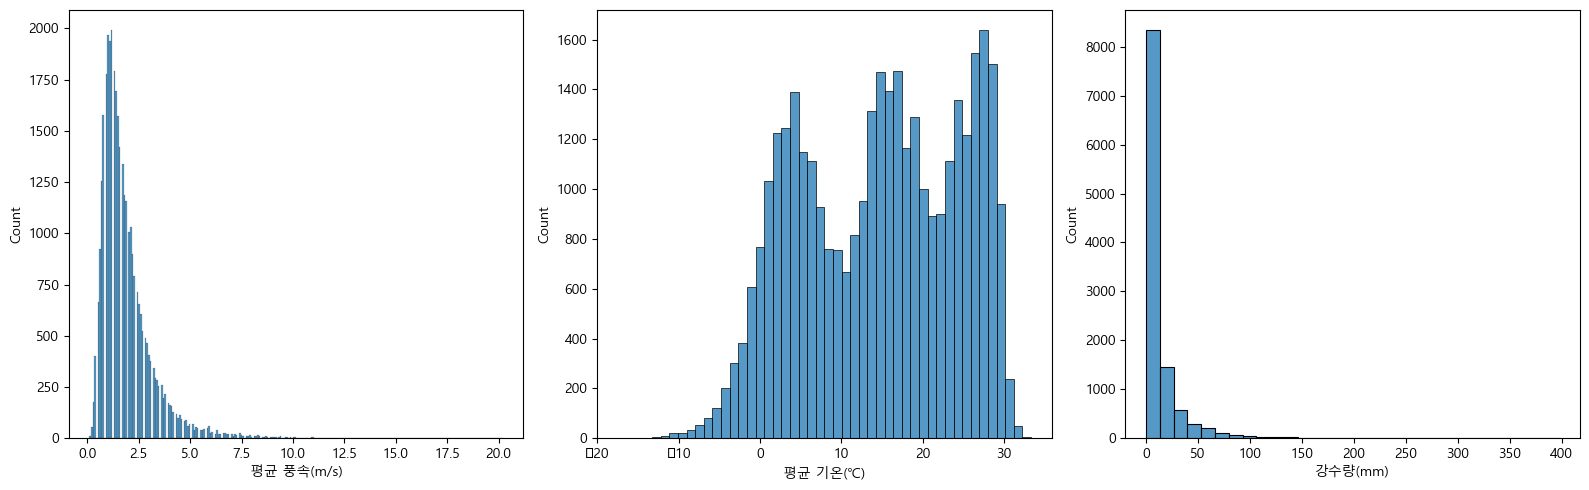

In [183]:
# histplot
temp = df[['avgWs', 'avgTa', 'sumRn']]
temp.columns = ['평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
plt.figure(figsize=(16,5))
for i in range(len(temp.columns)):    
    plt.subplot(1,3,i+1)
    if i == 2:
        sns.histplot(temp[temp['강수량(mm)'] > 0]['강수량(mm)'], bins=30) # 강수량 0mm 제외
    else:
        sns.histplot(temp.iloc[:,i])
plt.tight_layout()
plt.show()

In [184]:
# correlation
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
temp.columns = ['지점 번호', '평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
temp = temp.corr()
temp

,지점 번호,평균 풍속(m/s),평균 기온(℃),강수량(mm)
지점 번호,1.000000,-0.166262,0.027442,0.005872
평균 풍속(m/s),-0.166262,1.000000,-0.077567,0.043900
평균 기온(℃),0.027442,-0.077567,1.000000,0.128456
강수량(mm),0.005872,0.043900,0.128456,1.000000


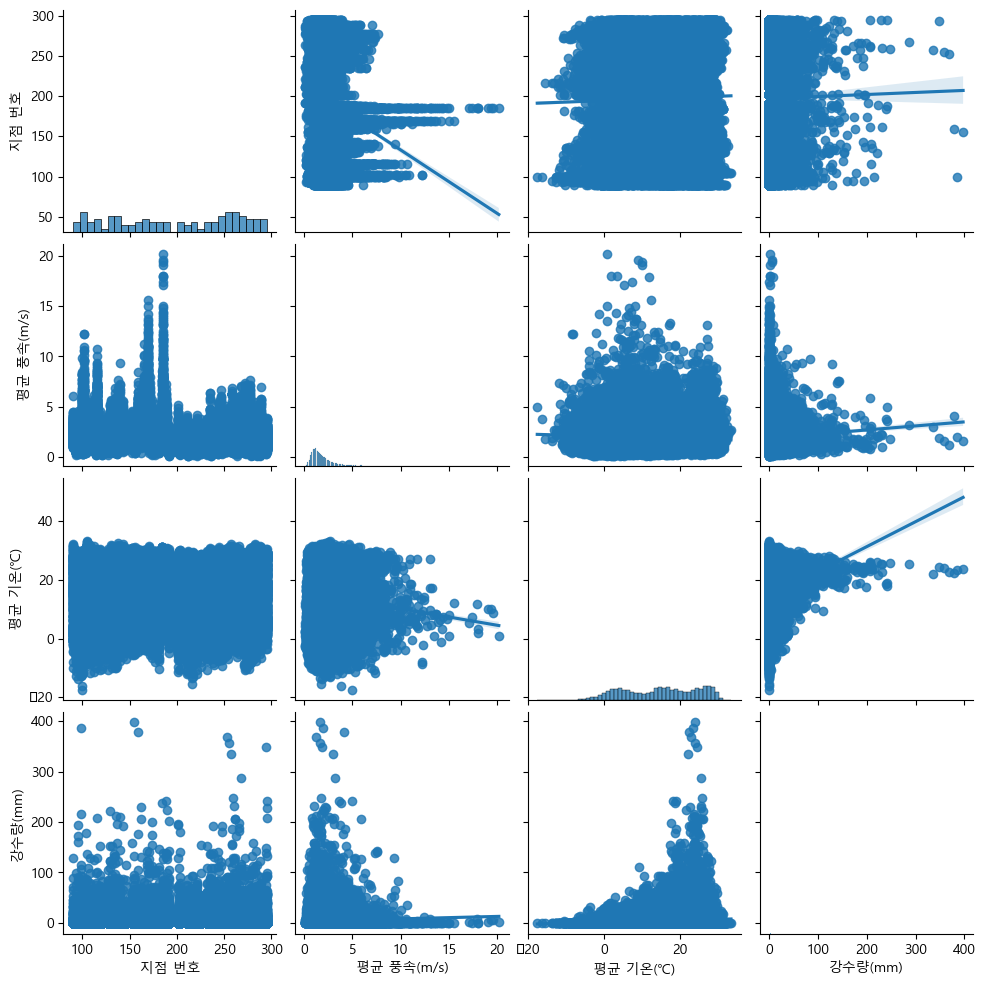

In [185]:
# pairplot
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
temp.columns = ['지점 번호', '평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
sns.pairplot(temp, kind='reg')
plt.show()

In [186]:
mask = np.array(temp.corr())
mask[np.tril_indices_from(mask)] = False
mask

array([[ 0.        , -0.16626228,  0.02744173,  0.0058724 ],
       [ 0.        ,  0.        , -0.07756663,  0.04390037],
       [ 0.        ,  0.        ,  0.        ,  0.12845566],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

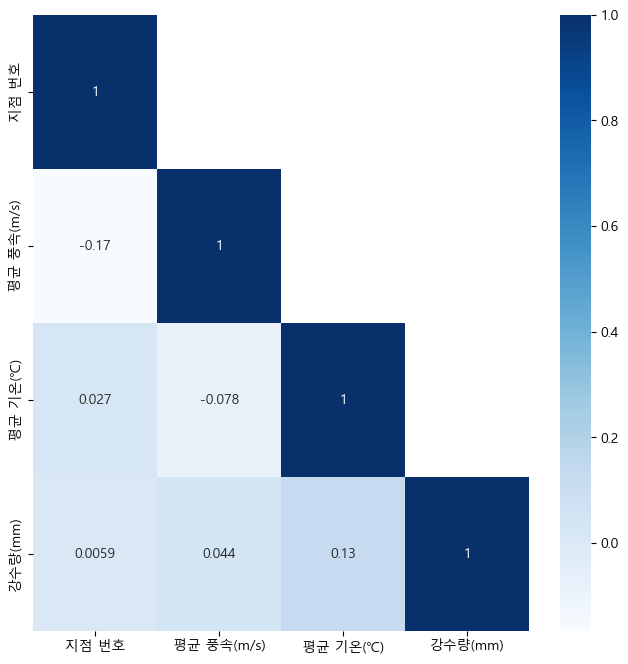

In [187]:
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
temp.columns = ['지점 번호', '평균 풍속(m/s)', '평균 기온(℃)', '강수량(mm)']
plt.figure(figsize=(8,8))
mask = np.array(temp.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(temp.corr(), mask = mask, annot=True, cmap='Blues')
plt.show()
# 대부분의 피어슨 상관계수 값이 0에 가까움 -> Feature 사이의 상관관계는 거의 없음 즉, 선형 독립

## 4) Feature engineering

In [188]:
'''
드론 운행 가능 기상 조건:
1. 강우/강설 : 0
2. 기온 : 0 ~ 40℃
3. 풍속 : 10 m/s 이하
''' 

'\n드론 운행 가능 기상 조건:\n1. 강우/강설 : 0\n2. 기온 : 0 ~ 40℃\n3. 풍속 : 10 m/s 이하\n'

In [189]:
df['tm'].dtype

dtype('<M8[ns]')

In [190]:
min_temp = 0
max_temp = 40
max_ws = 10

def feature_engineering(df, min_temp, max_temp, max_ws):
    df['ws_yn'] = df['avgWs'].map(lambda x: 1 if x<=max_ws else 0)
    df['temp_yn'] = df['avgTa'].map(lambda x: 1 if (x>=min_temp)&(x<=max_temp) else 0)
    df['rain_yn'] = df['sumRn'].map(lambda x: 0 if x>0 else 1)
    df['flight_yn'] = (df['ws_yn'] + df['temp_yn'] + df['rain_yn']).map(lambda x: 1 if x==3 else 0)
    df['yyyymm'] = df['tm'].dt.to_period('M')
    df['days_in_month'] = df['tm'].dt.days_in_month

    
    df_yn = df.groupby(['stnId', 'stnNm', 'yyyymm','days_in_month'])['flight_yn'].sum().reset_index(drop=False)
    df_yn['avg_yn_month'] = df_yn['flight_yn']/df_yn['days_in_month']
    df_yn.columns = [['stnId', 'stnNm', 'yyyymm', 'days_in_month', 'yn_month', 'avg_yn_month']]
    return df, df_yn

In [191]:
df_final, df_yn = feature_engineering(df, min_temp, max_temp, max_ws)

In [192]:
df_final

,stnId,stnNm,tm,avgWs,avgTa,sumRn,ws_yn,temp_yn,rain_yn,flight_yn,yyyymm,days_in_month
0,90,속초,2024-01-01,1.0,2.7,0.4,1,1,0,0,2024-01,31
1,90,속초,2024-01-02,1.8,2.7,0.0,1,1,1,1,2024-01,31
2,90,속초,2024-01-03,1.6,3.1,0.0,1,1,1,1,2024-01,31
3,90,속초,2024-01-04,1.9,2.9,0.0,1,1,1,1,2024-01,31
4,90,속초,2024-01-05,2.6,7.7,0.0,1,1,1,1,2024-01,31
...,...,...,...,...,...,...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,0.0,1,1,1,1,2024-12,31
35132,295,남해,2024-12-31,1.7,5.5,0.0,1,1,1,1,2024-12,31
35133,101,춘천,2024-12-25,1.7,5.5,0.0,1,1,1,1,2024-12,31
35134,172,고창,2024-05-20,1.7,5.5,0.0,1,1,1,1,2024-05,31


In [193]:
'''
yn_month : 월간 누적 비행 가능 횟수
avg_yn_month : yn_month를 해당 월의 총 일수로 나눈 컬럼 <정규화>
'''
df_yn

,stnId,stnNm,yyyymm,days_in_month,yn_month,avg_yn_month
0,90,속초,2024-01,31,17,0.548387
1,90,속초,2024-02,29,13,0.448276
2,90,속초,2024-03,31,18,0.580645
3,90,속초,2024-04,30,25,0.833333
4,90,속초,2024-05,31,24,0.774194
...,...,...,...,...,...,...
1147,295,남해,2024-08,31,28,0.903226
1148,295,남해,2024-09,30,24,0.800000
1149,295,남해,2024-10,31,20,0.645161
1150,295,남해,2024-11,30,25,0.833333


In [194]:
df_yn['stnNm'].squeeze().nunique()

96

## 5) csv파일 저장

In [195]:
weather_final_path = os.path.join(data_dir, r'원본(크롤링)\weather_final.csv')
weather_yn_path = os.path.join(data_dir, r'원본(크롤링)\weather_yn.csv')

df_final.to_csv(weather_final_path, index=False, encoding='cp949')
df_yn.to_csv(weather_yn_path, index=False, encoding='cp949')

## 6) 데이터 필터링


### 6.1) 비행 공역 데이터 불러오기

In [196]:
circle_table_path = os.path.join(data_dir, r'전처리\Circle_table.csv')
circle_table = pd.read_csv(circle_table_path, encoding='cp949')
circle_table

,구역 코드,위치,반경,위도,경도,지역
0,UA 2,전주(구성산),1.80,35.739167,127.007500,전주시
1,UA 3,대구(약산),0.70,35.739167,128.417222,대구시
2,UA 4,울산(봉화산),4.00,35.625278,129.092222,울산시
3,UA 5,남원(덕두산),4.50,35.411389,127.532500,남원시
4,UA 6,금산,2.10,34.736389,127.981111,금산시
5,UA 7,전주(홍산),1.20,35.828056,127.081111,전주시
6,UA 10,고창,4.00,35.386389,126.731389,고창시
7,UA 21,광주(방장산),3.00,35.449444,126.738056,광주시
8,UA 24,제주(구좌),2.80,33.478056,126.822778,제주시
9,UA 27,제주(지악산),1.20,33.300000,126.554444,제주시


In [197]:
NE_table_path = os.path.join(data_dir, r'전처리\NE_table.csv')
ne_table = pd.read_csv(NE_table_path, encoding='cp949')
ne_table

,구역 코드,위치,NE,지역
0,UA 9,양평,"[(37.45, 127.38333333333334), (37.502777777777...",양평시
1,UA 14,세종(공주),"[(36.45805555555556, 126.96388888888889), (36....",세종시
2,UA 19,수원(시화호),"[(37.212500000000006, 126.67472222222223), (37...",수원시
3,UA 25,광양(하동),"[(34.98777777777778, 127.72333333333333), (35....",광양시
4,UA 26,영월(장암산),"[(37.36972222222222, 128.39194444444445), (37....",영월시
5,* UA 31,인천(청라),"[(37.5625, 126.62666666666667), (37.565, 126.6...",인천시
6,* UA 33,청주(병천천),"[(36.647777777777776, 127.34972222222221), (36...",청주시
7,* UA 34,청주(미호천),"[(36.61388888888889, 127.3425), (36.6194444444...",청주시
8,* UA 35,김해,"[(35.34527777777778, 128.8063888888889), (35.3...",김해시
9,* UA 36,밀양,"[(35.46388888888889, 128.77416666666667), (35....",밀양시


#### 데이터 정제(지역명 통일화)

In [198]:
# stnNm '시' 추가 함수
def add_city_suffix(name):
    if name and not name.endswith("시"):
        return name + "시"
    return name

df_yn['stnNm'] = df_yn['stnNm'].map(add_city_suffix)

In [199]:
# df_yn '시' 추가 결과
df_yn

,stnId,stnNm,yyyymm,days_in_month,yn_month,avg_yn_month
0,90,속초시,2024-01,31,17,0.548387
1,90,속초시,2024-02,29,13,0.448276
2,90,속초시,2024-03,31,18,0.580645
3,90,속초시,2024-04,30,25,0.833333
4,90,속초시,2024-05,31,24,0.774194
...,...,...,...,...,...,...
1147,295,남해시,2024-08,31,28,0.903226
1148,295,남해시,2024-09,30,24,0.800000
1149,295,남해시,2024-10,31,20,0.645161
1150,295,남해시,2024-11,30,25,0.833333


#### 비행 공역 데이터 '지역'컬럼 Concat

In [200]:
df_area = pd.concat([circle_table['지역'], ne_table['지역']]).reset_index(drop = True)
cities = df_area.values.tolist()
cities

['전주시',
 '대구시',
 '울산시',
 '남원시',
 '금산시',
 '전주시',
 '고창시',
 '광주시',
 '제주시',
 '제주시',
 '천안시',
 '천안시',
 '천안시',
 '양평시',
 '대구시',
 '광주시',
 '광주시',
 '서울시',
 '양평시',
 '세종시',
 '수원시',
 '광양시',
 '영월시',
 '인천시',
 '청주시',
 '청주시',
 '김해시',
 '밀양시',
 '창원시',
 '울산시',
 '군산시',
 '대전시',
 '영월시',
 '대전시']

#### weather_yn_df(최적화 기상데이터) 생성

In [201]:
weather_yn_df = df_yn.loc[df_yn['stnNm'].squeeze().isin(cities)].reset_index(drop=True)
weather_yn_df.to_csv(os.path.join(data_dir, r'전처리\weather_yn_df.csv'), encoding = 'cp949', index=False)

In [202]:
weather_yn_df

,stnId,stnNm,yyyymm,days_in_month,yn_month,avg_yn_month
0,108,서울시,2024-01,31,10,0.322581
1,108,서울시,2024-02,29,18,0.620690
2,108,서울시,2024-03,31,19,0.612903
3,108,서울시,2024-04,30,26,0.866667
4,108,서울시,2024-05,31,23,0.741935
...,...,...,...,...,...,...
259,288,밀양시,2024-08,31,21,0.677419
260,288,밀양시,2024-09,30,25,0.833333
261,288,밀양시,2024-10,31,20,0.645161
262,288,밀양시,2024-11,30,26,0.866667


### 월별 비행 가능 횟수 지표 통계분석 시각화

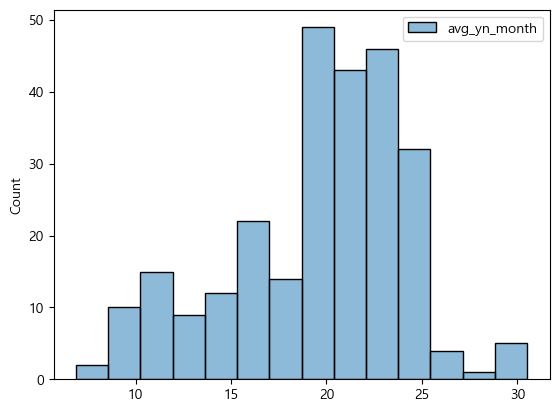

In [203]:
sns.histplot((weather_yn_df['avg_yn_month']*30.5))
plt.show()

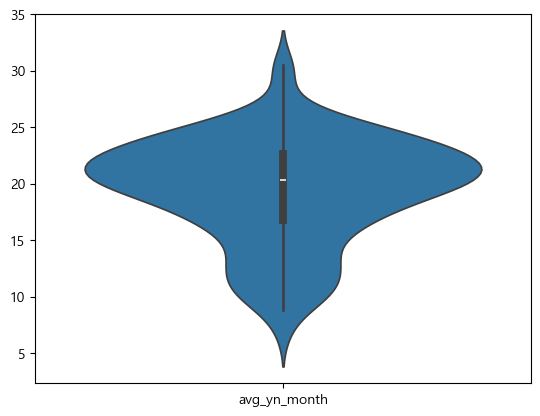

In [204]:
sns.violinplot((weather_yn_df['avg_yn_month']*30.5))
plt.show()

In [205]:

q1 = np.percentile((weather_yn_df['avg_yn_month']*30.5), 25)  # 25% 백분위수
q3 = np.percentile((weather_yn_df['avg_yn_month']*30.5), 75)
plt.figure(figsize=(8, 6))
ax = sns.boxplot((weather_yn_df['avg_yn_month']*30.5), color="skyblue")

x_min, x_max = plt.xlim()

plt.hlines(q1, xmin=x_min, xmax=x_max, colors="red", linestyles="--", label="25% Quantile")
plt.hlines(q3, xmin=x_min, xmax=x_max, colors="blue", linestyles="--", label="75% Quantile")

plt.xlabels('연간 월 평균 가능 일 수)
# 25% 및 75% 수치 표시 (텍스트 추가)
plt.text(x_max, q1, f"  25%: {q1:.2f}", verticalalignment="center", color="red", fontsize=12)
plt.text(x_max, q3, f"  75%: {q3:.2f}", verticalalignment="center", color="blue", fontsize=12)
# 범례 및 표시
plt.legend()
plt.show()

SyntaxError: unterminated string literal (detected at line 11) (1079346783.py, line 11)